In [48]:
#Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
%matplotlib inline
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

In [ ]:
dataset_train = pd.read_csv("/content/train.csv")
dataset_train.head()

In [ ]:
dataset_train.info()

In [51]:
# Extract the values for the "SALES_TYPE" column
Sales_type_data= dataset_train['SALES_TYPE'].values
# Create a LabelEncoder object
encoder = LabelEncoder()

# Fit the encoder to the sales type data
encoder.fit(Sales_type_data)

# Encode the location data
encoded_sales_type = encoder.transform(Sales_type_data)
dataset_train['SALES_TYPE'] =encoded_sales_type

In [ ]:
dataset_train

In [ ]:
training_set = dataset_train.iloc[:,4:5].values
print(training_set)
print(training_set.shape)

In [ ]:
dataset_train.info()

In [ ]:
scaler = MinMaxScaler(feature_range = (0,1))
scaled_training_set = scaler.fit_transform(training_set)

scaled_training_set.shape

In [ ]:
x_train = []
y_train = []
for i in range(60,331):
  x_train.append(scaled_training_set[i-60:i,0])
  y_train.append(scaled_training_set[i,0])
x_train = np.array(x_train)
y_train = np.array(y_train)

print(x_train.shape)
print(y_train.shape)

In [ ]:
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1],1))
x_train.shape

In [39]:
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences=True, input_shape = (x_train.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))


In [ ]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
hist = regressor.fit(x_train, y_train, epochs = 100, batch_size = 32, verbose = 2)

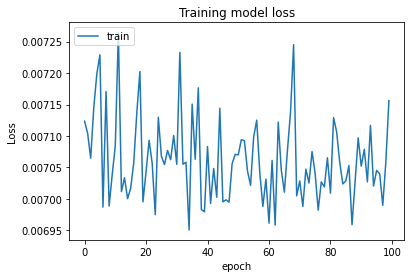

In [41]:
plt.plot(hist.history['loss'])
plt.title('Training model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train'], loc = 'upper left')
plt.show()

In [102]:
dataset_test = pd.read_csv("/content/test.csv")

# Calculate the IQR for each column
Q1 = dataset_test.quantile(0.25)
Q3 = dataset_test.quantile(0.75)
IQR = Q3 - Q1

# Identify any outliers as values that are more than 1.5 times the IQR away from the median
outliers = ((dataset_test < (Q1 - 1.5 * IQR)) | (dataset_test > (Q3 + 1.5 * IQR))).any(axis=1)

# Drop rows containing outliers
dataset_test = dataset_test[~outliers]

dataset_test = dataset_test.iloc[:,4:5]
y_test = dataset_test.iloc[0:,0:].values

<ipython-input-102-e32a5fc50d21>:9: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers = ((dataset_test < (Q1 - 1.5 * IQR)) | (dataset_test > (Q3 + 1.5 * IQR))).any(axis=1)


In [103]:


inputunit = dataset_test.iloc[:,0:].values
inputunit_scaled = scaler.transform(inputunit)
inputunit_scaled.shape

x_test = []
length = len(dataset_test)
timestep = 5
for i in range (timestep,length):
  x_test.append(inputunit[i-timestep:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
x_test.shape

(99, 5, 1)

In [ ]:
y_test

In [105]:
y_pred = regressor.predict(x_test)

4/4 [==============================] - 0s 4ms/step


In [84]:
predicted_units = scaler.inverse_transform(y_pred)

In [ ]:
predicted_units

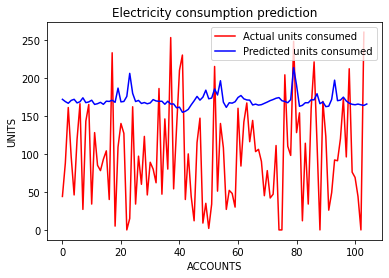

In [107]:
plt.plot(y_test, color = 'red',label = 'Actual units consumed')
plt.plot(predicted_units, color = 'blue', label = 'Predicted units consumed')
plt.title('Electricity consumption prediction')
plt.xlabel('ACCOUNTS')
plt.ylabel('UNITS')
plt.legend()